# **DeepIM: Deep Iterative Matching for 6D Pose Estimation**
---
This notebook provides a comprehensive overview of **DeepIM**, a robust model architecture designed for **6D object pose estimation**. DeepIM effectively addresses challenges, such as handling **textureless objects and unseen objects** and various other factors that impact pose estimation accuracy.

## **1. Introduction**
DeepIM is a convolutional neural network developed to estimate the **6D pose** of various objects, including textureless objects and unseen objects. It decouples the pose estimation flow into **rotation** and **translation** for more accurate predictions. Its main contributions include:

- A robust framework for 6D object pose estimation under diverse conditions.
- Adoption of **FlowNet Simple** as feature extractor, leveraging  accuracy using **optical flow** reprsentation to improve accuracy.
- Use of a **disentangled transformation representation** for SE(3) transformations,   
  which enables better generalization across unseen objects and increases estimation precision by separating rotation and translation updates.
- Introduction of novel **Pose Matching Loss**, optimizing both rotation and translation simultaneously   
  based on differences of size and alignment in 2D reprojected scenes.

## **2. Dataset**
### **2-1. Dataset Type**

#### **LINEMOD Dataset**
This dataset contains **13 objects** with 6D pose annotations. 
It provides:
- **Highly textured objects** with uniform backgrounds.
- **Minimal occlusions** in most frames, enabling the evaluation of baseline pose estimation methods.
- Synthetic training data generation to improve robustness:
  - Synthetic images are created by rotating object models randomly within the elevation range of the dataset.
  - The translation is generated based on the mean and standard deviation of the training set.
  - Backgrounds are replaced with randomly selected indoor images from the PASCAL VOC dataset.

#### **OccludedLINEMOD Dataset**
This dataset contains **1,214 RGB-D frames** with 6D pose annotations for **8 objects**. 
It provides:
- A benchmark for 6D pose estimation under **significant occlusions**.
- Challenging scenarios with multiple objects partially obstructed.
- Synthetic training data generation to introduce occlusions:
  - Multiple objects (3 to 8) are rendered into a single image to mimic real-world occlusions.
  - Object poses are generated randomly, ensuring the elevation range is consistent with the training set.
  - Translations of objects are based on distributions observed in the YCB-Video dataset, with small Gaussian noise added.
  - Variations in lighting conditions are added to synthetic images to enhance generalization.

#### **YCB-Video Dataset**
This dataset contains **133,827 RGB-D frames across 92 videos**. 
It provides:
- **21 objects** with 6D pose annotations, including symmetric objects.
- Real-world scenarios with severe occlusions and symmetric objects.
- Synthetic training data generated on the fly:
  - Synthetic images include target objects and an additional nearby object to introduce partial occlusion.
  - Backgrounds and lighting conditions are randomized to improve robustness.
- A variety of object interactions and complex arrangements, making it a comprehensive dataset for real-world 6D pose estimation.

## **3. DeepIM Architecture**
### **3.1. Load Dataset**

In [ ]:
# Copyright (c) 2020 NVIDIA Corporation. All rights reserved.
# This work is licensed under the NVIDIA Source Code License - Non-commercial. Full
# text can be found in LICENSE.md

"""
Factory.py: Factory method for easily getting imdbs by name.
"""

__sets = {}

# Import library and custom modules
import datasets.ycb_video
import datasets.background
import numpy as np

# Prepare ycb-video dataset
for split in ['train', 'val', 'keyframe', 'trainval', 'debug']: # Iterate over the dataset splits
    name = 'ycb_video_{}'.format(split) # Generate the dataset name for each split
    #print name
    __sets[name] = (lambda split=split: # For each dataset name, create a lambda function to generate a YCB object and add it to __sets
            datasets.YCBVideo(split)) 

# Prepare background dataset
for split in ['coco', 'rgbd', 'nvidia', 'table', 'isaac', 'texture', 'sunrgbd']: # Iterate over the dataset splits
    name = 'background_{}'.format(split) # Generate the dataset name for each split
    print(name)
    __sets[name] = (lambda split=split: # For each dataset name, create a lambda function to generate a background image and add it to __sets
            datasets.BackgroundDataset(split))
    
# Define a function to retrieve a dataset by its name
def get_dataset(name):
    """Get an imdb (image database) by name."""
    if name not in __sets:
        raise KeyError('Unknown dataset: {}'.format(name))
    return __sets[name]()

def list_datasets():
    """List all registered imdbs."""
    return __sets.keys()

### **3.2. YCB Renderer**

### **3.3. Zoom In Operation**

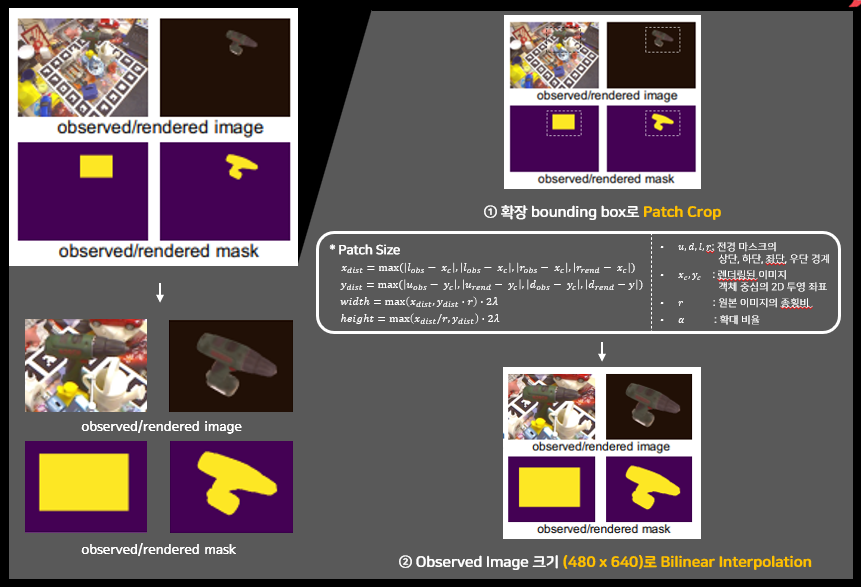



In [ ]:
# Copyright (c) 2020 NVIDIA Corporation. All rights reserved.
# This work is licensed under the NVIDIA Source Code License - Non-commercial. Full
# text can be found in LICENSE.md

# Import libraries and configuration
import numpy as np
import cv2
from fcn.config import cfg

# Define a fuction to output zoomed images
def zoom_images(image_blob, image_real, image_imgn, image_flow, pose_src, intrinsic_matrix):
    """
    A function to zoom-in observed/rendered images and observed/rendered masks

    Args:
        image_blob          : Tensor containing images from dataset.
        image_real          : Real observed images.
        image_imgn          : Rendered images.
        image_flow          : Optical flow between images.
        pose_src            : Ground truth pose, contains pose parameters.
        intrinsic_matrix    : Camera intrinsic matrix, contains focal length and center position.

    Returns:
        image_zoom          : Zoomed-in image_blob.
        image_real_zoom     : Zoomed-in real observed images.
        image_imgn_zoom     : Zoomed-in rendered images.
        flow_zoom           : Zoomed-in optical flow.
        mask_real           : Mask for real image region.
        mask_imgn           : Mask for rendered image region.
        zoom_factor         : The zoom factors used for transformation.
    """

    batch_size = image_real.shape[0]
    height = image_real.shape[1]
    width = image_real.shape[2]
    ratio = float(height) / float(width) # Calculate image height-width ratio

    # Declare arrays for data storage
    image_zoom = np.zeros((batch_size, height ,width, 3), dtype=np.float32)
    image_real_zoom = np.zeros((batch_size, height ,width, 3), dtype=np.float32)
    image_imgn_zoom = np.zeros((batch_size, height ,width, 3), dtype=np.float32)
    flow_zoom = np.zeros((batch_size, height ,width, 2), dtype=np.float32)
    mask_real = np.zeros((batch_size, height ,width, 1), dtype=np.float32)
    mask_imgn = np.zeros((batch_size, height ,width, 1), dtype=np.float32)
    zoom_factor = np.zeros((batch_size, 4), dtype=np.float32)

    for i in range(batch_size):

        # real image
        nz_y, nz_x = np.where(image_real[i, :, :, 0] > 0) # Find non-zero pixels in the real image

        obj_real_start_x = np.min(nz_x) # Find the leftmost x-coordinate
        obj_real_end_x = np.max(nz_x) # Find the rightmost x-coordinate
        obj_real_start_y = np.min(nz_y) # Find the topmost y-coordinate
        obj_real_end_y = np.max(nz_y) # Find the bottommost y-coordinate
        # obj_real_c_x = (obj_real_start_x + obj_real_end_x) * 0.5 
        # obj_real_c_y = (obj_real_start_y + obj_real_end_y) * 0.5 

        # rendered image
        nz_y, nz_x = np.where(image_imgn[i, :, :, 0] > 0) # Find non-zero pixels in the rendered image

        obj_imgn_start_x = np.min(nz_x) # Find the leftmost x-coordinate
        obj_imgn_end_x = np.max(nz_x) # Find the righttmost x-coordinate
        obj_imgn_start_y = np.min(nz_y) # Find the topmost y-coordinate
        obj_imgn_end_y = np.max(nz_y) # Find the bottommost y-coordinate

        # Compute the camera center in 2D 
        # K: intrinsic_matrix
        # P: the current location of the 3D object
        # Result: [u,v,w]
        # u, v: 
        # w: 
        obj_imgn_c = np.dot(intrinsic_matrix, pose_src[i, 6:])

        # zoom-in center = [u/w, v/w]
        zoom_c_x = obj_imgn_c[0] / obj_imgn_c[2] # Calculate x-coordinate of the zoom center
        zoom_c_y = obj_imgn_c[1] / obj_imgn_c[2] # Calculate y-coordinate of the zoom center

        # crop 
        left_dist = max(zoom_c_x - obj_imgn_start_x, zoom_c_x - obj_real_start_x)
        right_dist = max(obj_imgn_end_x - zoom_c_x, obj_real_end_x - zoom_c_x)
        up_dist = max(zoom_c_y - obj_imgn_start_y, zoom_c_y - obj_real_start_y)
        down_dist = max(obj_real_end_y - zoom_c_y, obj_imgn_end_y - zoom_c_y)

        # crop_height = np.max([up_dist, down_dist])
        # crop_width = np.max([left_dist, right_dist])

        # Define height, width for image/mask crop
        crop_height = np.max([ratio * right_dist, ratio * left_dist, up_dist, down_dist]) * 2
        crop_width = crop_height / ratio

        # Affine transformation (Zoom-in operation)
        x1 = zoom_c_x - crop_width / 2 # Left x-coordinate of crop
        x2 = zoom_c_x + crop_width / 2 # Right x-coordinate of crop
        y1 = zoom_c_y - crop_height / 2 # Top x-coordinate of crop
        y2 = zoom_c_y + crop_height / 2 # Bottom x-coordinate of crop

        # Prepare points for affine transformation
        pts1 = np.float32([[x1, y1], [x1, y2], [x2, y1]]) # Points form the cropped region
        pts2 = np.float32([[0, 0], [0, height], [width, 0]]) # Points for affine transformation target
        affine_matrix = cv2.getAffineTransform(pts1, pts2) # Compute affine transformation matrix

        # Apply affine transformation to images and flows
        idx = int(pose_src[i, 0])
        image_zoom[i, :, :, :] = cv2.warpAffine(image_blob[idx, :, :, :], affine_matrix, (width, height))
        image_real_zoom[i, :, :, :] = cv2.warpAffine(image_real[i, :, :, :], affine_matrix, (width, height))
        image_imgn_zoom[i, :, :, :] = cv2.warpAffine(image_imgn[i, :, :, :], affine_matrix, (width, height))
        flow_zoom[i, :, :, :] =  cv2.warpAffine(image_flow[i, :, :, :], affine_matrix, (width, height))
        flow_zoom[i, :, :, 0] *= affine_matrix[0, 0] 
        flow_zoom[i, :, :, 1] *= affine_matrix[1, 1]

        # Construct masks for zoomed images
        nz_y, nz_x = np.where(image_imgn_zoom[i, :, :, 0] > 0) # Find non-zero pixels in the zoomed rendered image
        x1 = int(np.min(nz_x)) # Leftmost x-coordinate in zoomed region
        x2 = int(np.max(nz_x)) # Rightmost
        y1 = int(np.min(nz_y)) # Topmost
        y2 = int(np.max(nz_y)) # Bottommost
        mask_real[i, y1:y2, x1:x2, :] = 1.0 # Create mask for real image
        mask_imgn[i, nz_y, nz_x, :] = 1.0 # Create mask for rendered image

        # image_zoom[i, :, :, :] -= cfg.PIXEL_MEANS
        # image_real_zoom[i, :, :, :] -= cfg.PIXEL_MEANS
        # image_imgn_zoom[i, :, :, :] -= cfg.PIXEL_MEANS

        # Store zoom factors
        zoom_factor[i, 0] = affine_matrix[0, 0] # Store zoom factor for x-axis
        zoom_factor[i, 1] = affine_matrix[1, 1] # Store zoom factor for y-axis
        zoom_factor[i, 2] = affine_matrix[0, 2] # Store translation factor for x-axis
        zoom_factor[i, 3] = affine_matrix[1, 2] # Store translation factor for y-axis

    return image_zoom, image_real_zoom, image_imgn_zoom, flow_zoom, mask_real, mask_imgn, zoom_factor

### **3.4. Disentangled Transformation Representation**
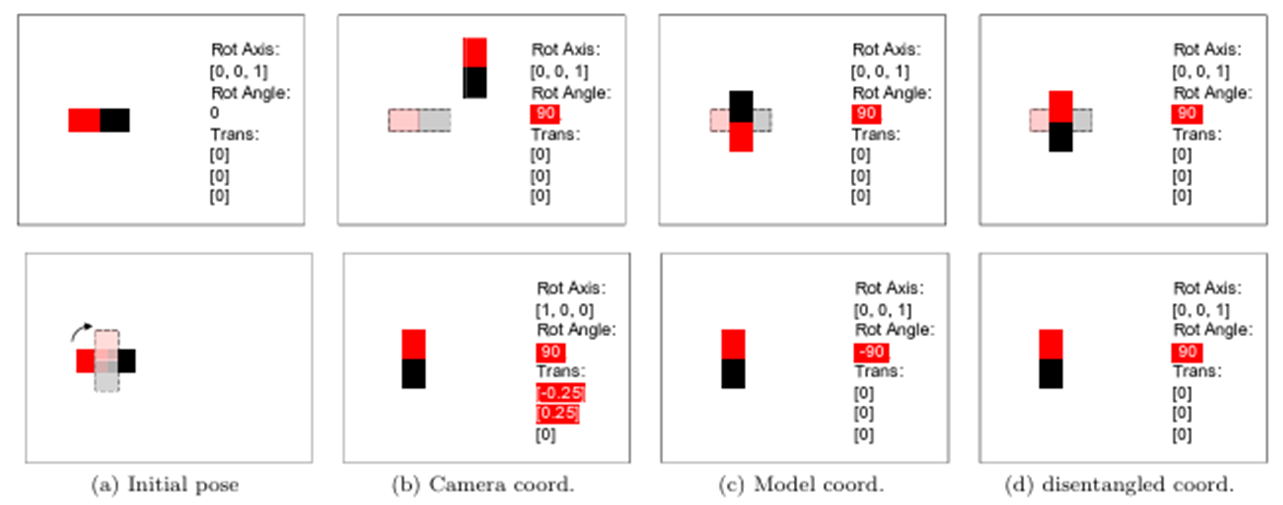

- **Rotation**
    - Rotation Center: The center of a object in the **3D object model coordinates**
    - Rotation Axis: The axis **parallel to camera coordinates**

- **Translation**

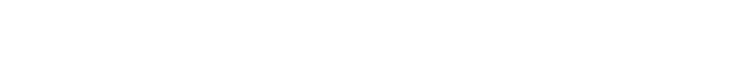

In [ ]:
# Copyright (c) 2020 NVIDIA Corporation. All rights reserved.
# This work is licensed under the NVIDIA Source Code License - Non-commercial. Full
# text can be found in LICENSE.md

"""
se3.py: SE(3) method applied with disentangled transformation representation
"""

# Import libraries
import numpy as np
import numpy.matlib as npm
from transforms3d.quaternions import mat2quat, quat2mat
import scipy.stats as sci_stats

# RT: 3x4 matrix that shows 
def se3_inverse(RT):
    """
        se3_inverse: Calculate inverted transformation of the given SE(3) matrix

            Args:
                RT: 3x4 matrix that shows SE(3) transformation
            Return: 
                RT_new: the inverted SE(3) transformation
    """
    R = RT[0:3, 0:3] # Extract the rotation matrix (R) from the 3x4 matrix
    T = RT[0:3, 3].reshape((3,1)) # Extract the translation vector (T) and reshape it to 3x1

    RT_new = np.zeros((3, 4), dtype=np.float32) # Initialize a new 3x4 matrix to store the inverted transformation
    RT_new[0:3, 0:3] = R.transpose() # Set the rotation part as the transpose of R
    RT_new[0:3, 3] = -1 * np.dot(R.transpose(), T).reshape((3)) # Compute the inverse translation: -R^T *T
    return RT_new 

def se3_mul(RT1, RT2):
    """
        se3_mul: Calculate inverted transformation of the given SE(3) matrix
        
            Args:
                RT: 3x4 matrix that shows SE(3) transformation
            Return: 
                RT_new: the inverted SE(3) transformation
    """
    # Extract the rotation matrix (R1) and translation vector (T1) from RT1
    R1 = RT1[0:3, 0:3]
    T1 = RT1[0:3, 3].reshape((3,1))

    # Extract the rotation matrix (R2) and translation vector (T2) from RT2
    R2 = RT2[0:3, 0:3]
    T2 = RT2[0:3, 3].reshape((3,1))

    # Initialize a new 3x4 matrix to store the resulting SE(3) transformation
    RT_new = np.zeros((3, 4), dtype=np.float32)
    # Compute the new rotation matrix: R1 * R2
    RT_new[0:3, 0:3] = np.dot(R1, R2)
    T_new = np.dot(R1, T2) + T1 
    # Compute the new translation vector: R1 * T2 + T1
    RT_new[0:3, 3] = T_new.reshape((3))
    return RT_new

# T_inv_transform
def T_inv_transform(T_src, T_tgt):
    '''
        T_inv_transform: Compute relative translation between two 3D points
        Args:
            T_src: original 3D location (x,y,z)
            T_tgt: target 3D translation (x,y,z)

        return: 
            T_delta: delta in pixel 
    '''
    T_delta = np.zeros((3, ), dtype=np.float32) # Initialize an array to store the transformation delta

    # Compute the x-axis transformation delta
    T_delta[0] = T_tgt[0] / T_tgt[2] - T_src[0] / T_src[2]
    # Compute the y-axis transformation delta
    T_delta[1] = T_tgt[1] / T_tgt[2] - T_src[1] / T_src[2]
    # Compute the depth transformation delta (log scale)
    T_delta[2] = np.log(T_src[2] / T_tgt[2])

    return T_delta


def rotation_x(theta):
    # Convert the angle from degrees to radians
    t = theta * np.pi / 180.0
    # Initialize the 3x3 rotation matrix
    R = np.zeros((3, 3), dtype=np.float32)
    R[0, 0] = 1 # x-axis remains fixed
    R[1, 1] = np.cos(t)
    R[1, 2] = -np.sin(t)
    R[2, 1] = np.sin(t)
    R[2, 2] = np.cos(t)
    return R

def rotation_y(theta):
    # Convert the angle from degrees to radians
    t = theta * np.pi / 180.0
    # Initialize the 3x3 rotation matrix
    R = np.zeros((3, 3), dtype=np.float32)
    R[0, 0] = np.cos(t)
    R[0, 2] = np.sin(t)
    R[1, 1] = 1 # y-axis remains fixed
    R[2, 0] = -np.sin(t)
    R[2, 2] = np.cos(t)
    return R

def rotation_z(theta):
    # Convert the angle from degrees to radians
    t = theta * np.pi / 180.0
    # Initialize the 3x3 rotation matrix
    R = np.zeros((3, 3), dtype=np.float32)
    R[0, 0] = np.cos(t)
    R[0, 1] = -np.sin(t)
    R[1, 0] = np.sin(t)
    R[1, 1] = np.cos(t)
    R[2, 2] = 1 # z-axis remains fixed
    return R


# Q is a Nx4 numpy matrix and contains the quaternions to average in the rows.
# The quaternions are arranged as (w,x,y,z), with w being the scalar
# The result will be the average quaternion of the input. Note that the signs
# of the output quaternion can be reversed, since q and -q describe the same orientation
def averageQuaternions(Q):
    # Number of quaternions to average
    M = Q.shape[0]
    # Initialize a 4x4 matrix to store the covariance-like matrix
    A = npm.zeros(shape=(4,4))

    # Compute the outer product of each quaternion and acculmulate
    for i in range(0,M):
        q = Q[i,:]
        # multiply q with its transposed version q' and add A
        A = np.outer(q,q) + A

    # Normalize the matrix by dividing by the number of quaternions
    A = (1.0/M)*A
    # Compute eigenvalues and eigenvectors of the matrix
    eigenValues, eigenVectors = np.linalg.eig(A)
    # Sort the eigenvectors by their corresponding eigenvalues in descending order
    eigenVectors = eigenVectors[:,eigenValues.argsort()[::-1]]
    # Return the real part of the eigenvector corresponding to the largest eigenvalue
    return np.real(eigenVectors[:,0].A1)

### **3.4. FlowNet Simple Network**

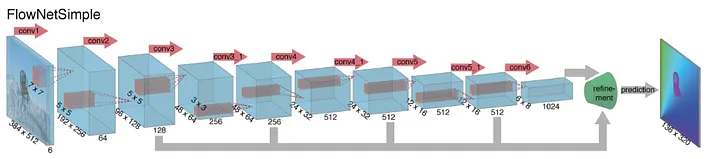

FlowNetS, proposed in the paper "Learning Optical Flow with Convolutional Networks," is a model that uses CNNs to **predict optical flow between pairs of images**. This architecture is structured as follows:

- Input: A **6-channel input** combining two images (3-channel RGB × 2).
- Network Architecture: A series of convolutional layers are used to progressively **extract high-level feature maps**, which are then utilized to predict optical flow.
- Prediction Process: **Optical flow is predicted** at the output of each layer, and it is **upsampled** to be passed to the next stage.

In [ ]:

# Import libraries and custom modules
import torch
import torch.nn as nn
from fcn.config import cfg
from torch.nn.init import kaiming_normal_
from point_matching_loss.PMLoss import PMLoss

# Define a convolutional layer with optional BatchNorm and LeakyReLU activation
def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )

# Define a flow prediction layer to output optical flow (2 channels)
def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)

# Define a deconvolutional (upsampling) layer
def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1,inplace=True)
    )

# Define a fully-connected layer with optional Leaky ReLU activation
def fc(in_planes, out_planes, relu=True):
    if relu:
        return nn.Sequential(
            nn.Linear(in_planes, out_planes),
            nn.LeakyReLU(0.1, inplace=True))
    else:
        return nn.Linear(in_planes, out_planes)

# Crop the input tensor to match the size of the target tensor
def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]

# Transformation function for 3D poses (older version)
def t_transform_old(T_src, T_delta, zoom_factor, num_classes):
    '''
    :param T_src: (x1, y1, z1)
    :param T_delta: (dx, dy, dz)
    :return: T_tgt: (x2, y2, z2)
    '''

    T_src = T_src.repeat(1, num_classes)
    factor_x = torch.unsqueeze(zoom_factor[:, 0], 1)
    factor_y = torch.unsqueeze(zoom_factor[:, 1], 1)

    vx_0 = torch.mul(T_delta[:, 0::3], factor_x.repeat(1, num_classes))
    vy_0 = torch.mul(T_delta[:, 1::3], factor_y.repeat(1, num_classes))

    vz = torch.div(T_src[:, 2::3], torch.exp(T_delta[:, 2::3]))
    vx = torch.mul(vz, torch.addcdiv(vx_0, 1.0, T_src[:, 0::3], T_src[:, 2::3]))
    vy = torch.mul(vz, torch.addcdiv(vy_0, 1.0, T_src[:, 1::3], T_src[:, 2::3]))

    T_tgt = torch.zeros_like(T_src)
    T_tgt[:, 0::3] = vx
    T_tgt[:, 1::3] = vy
    T_tgt[:, 2::3] = vz

    return T_tgt


# Transformation function for 3D poses (optimized version with scaling factor)
def t_transform(T_src, T_delta, zoom_factor, num_classes):
    '''
    :param T_src: (x1, y1, z1)
    :param T_delta: (dx, dy, dz)
    :return: T_tgt: (x2, y2, z2)
    '''

    weight = 10.0
    T_src = T_src.repeat(1, num_classes)
    vz = torch.div(T_src[:, 2::3], torch.exp(T_delta[:, 2::3] / weight))
    vx = torch.mul(vz, torch.addcdiv(T_delta[:, 0::3] / weight, 1.0, T_src[:, 0::3], T_src[:, 2::3]))
    vy = torch.mul(vz, torch.addcdiv(T_delta[:, 1::3] / weight, 1.0, T_src[:, 1::3], T_src[:, 2::3]))

    T_tgt = torch.zeros_like(T_src)
    T_tgt[:, 0::3] = vx
    T_tgt[:, 1::3] = vy
    T_tgt[:, 2::3] = vz

    return T_tgt

# Transformation function for 3D poses (specific to depth)
def t_transform_depth(T_src, T_delta, num_classes):
    '''
    :param T_src: (x1, y1, z1)
    :param T_delta: (dx, dy, dz)
    :return: T_tgt: (x2, y2, z2)
    '''

    T_src = T_src.repeat(1, num_classes)
    T_tgt = torch.zeros_like(T_src)
    T_tgt = T_src + T_delta

    return T_tgt


# Define FlowNet Simple architecture, which learns optical flow
class FlowNetS(nn.Module):
    expansion = 1

    def __init__(self, num_classes, batchNorm=True):
        '''
        Initialize FlowNetS with multiple convolutional, fully connected, and deconvolutional layers.

        Args:
            num_classes: Number of object classes
            batchNorm: Whether to use BatchNorm in convolutional layers
        '''
        super(FlowNetS,self).__init__()

        self.num_classes = num_classes
        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,   6,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024, 1024)

        # Fully connected layers for pose estimation
        self.fc6 = fc(8 * 10 * 1024, 256, relu=True)
        self.fc7 = fc(256, 256, relu=True)
        self.fcr = fc(256, 4 * num_classes, relu=False)
        self.fct = fc(256, 3 * num_classes, relu=False)
        self.pml = PMLoss()

        # Deconvolutional layers for upsampling
        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        # Flow prediction layers
        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        # Upsampling layers for optical flow
        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x, weights_rot, poses_src, poses_tgt, extents, points, zoom_factor):
        '''
        Forward pass for FlowNetS.

        Args:
            x: Input tensor
            weights_rot: Weights for quaternion prediction
            poses_src: Source poses
            poses_tgt: Target poses
            extents: Object extents
            points: 3D points of the object
            zoom_factor: Scaling factors for the input

        Returns:
            Flows, pose loss, quaternion, and translation
        '''

        # Forward pass (feature extraction) through convolutional layers
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        # Pose estimation (quaternion and translation prediction)
        out_conv6_flatten = out_conv6.view(out_conv6.size(0), -1) # Convert high-level feature map to flattened feature vector
        out_fc6 = self.fc6(out_conv6_flatten)
        out_fc7 = self.fc7(out_fc6)
        # Rotation prediction
        out_fcr = self.fcr(out_fc7)
        quaternion = nn.functional.normalize(torch.mul(out_fcr, weights_rot))
        # Translation prediction
        translation_delta = self.fct(out_fc7)
        if cfg.INPUT == 'COLOR' and cfg.TRAIN.T_TRANSFORM_DEPTH == False:
            translation = t_transform(poses_src[:, 6:], translation_delta, zoom_factor, self.num_classes)
        else:
            translation = t_transform_depth(poses_src[:, 6:], translation_delta, self.num_classes)

        # Pose loss (pose-matcting loss) Calculation
        loss_pose = self.pml(quaternion, translation, poses_src, poses_tgt, extents, points)

        # Optical flow prediction and refinement by predicting optical flow of various resolutions
        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if self.training:
            return [flow2,flow3,flow4,flow5,flow6], loss_pose, quaternion, translation
        else:
            return quaternion, translation

    def weight_parameters(self):
        '''Retrieve all weight parameters in the network.'''
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        '''Retrieve all bias parameters in the network.'''
        return [param for name, param in self.named_parameters() if 'bias' in name]

# Function to create FlowNetS model with optional pretrained weights
def flownets(num_classes, data=None):
    """
    FlowNet Simple model architecture 
    from the "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)

    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(num_classes, batchNorm=False)
    if data is not None:
        model_dict = model.state_dict()
        print('model keys')
        print('=================================================')
        for k, v in model_dict.items():
            print(k)
        print('=================================================')

        print('data keys')
        print('=================================================')
        for k, v in data['state_dict'].items():
            print(k)
        print('=================================================')

        pretrained_dict = {k: v for k, v in data['state_dict'].items() if k in model_dict and v.size() == model_dict[k].size()}
        print('load the following keys from the pretrained model')
        print('=================================================')
        for k, v in pretrained_dict.items():
            print(k)
        print('=================================================')
        model_dict.update(pretrained_dict) 
        model.load_state_dict(model_dict)
    return model

# Function to create FlowNetS with BatchNorm and optional pretrained weights
def flownets_bn(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)

    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=True)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model

### **3.5. Point Matching Loss.**

### **3.4. DeepIM Network**

In [ ]:
# Copyright (c) 2020 NVIDIA Corporation. All rights reserved.
# This work is licensed under the NVIDIA Source Code License - Non-commercial. Full
# text can be found in LICENSE.md

# Import libraries and custom modules
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import time
import os
import sys
import math
import numpy as np
import cv2
import scipy
import threading
import cupy
import copy

from fcn.config import cfg
from fcn.multiscaleloss import multiscaleEPE, realEPE
from transforms3d.quaternions import mat2quat, quat2mat, qmult
from transforms3d.euler import mat2euler, euler2mat, euler2quat, quat2euler
from utils.show_flows import *
from utils.se3 import T_inv_transform, se3_mul, se3_inverse
from utils.zoom_in import zoom_images
from utils.pose_error import re, te

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return '{:.3f} ({:.3f})'.format(self.val, self.avg)

def train(train_loader, background_loader, network, optimizer, epoch, num_iterations):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    epoch_size = len(train_loader)
    enum_background = enumerate(background_loader)

    # Declare tensors for data storage
    num = cfg.TRAIN.IMS_PER_BATCH * cfg.TRAIN.MAX_OBJECT_PER_IMAGE
    height = cfg.TRAIN.SYN_HEIGHT
    width = cfg.TRAIN.SYN_WIDTH
    input_blob_color = torch.cuda.FloatTensor(num, 6, height, width).detach()
    image_real_blob_color = torch.cuda.FloatTensor(num, 3, height, width).detach()
    image_tgt_blob_color = torch.cuda.FloatTensor(num, 3, height, width).detach()
    image_src_blob_color = torch.cuda.FloatTensor(num, 3, height, width).detach()
    input_blob_depth = torch.cuda.FloatTensor(num, 6, height, width).detach()
    image_real_blob_depth = torch.cuda.FloatTensor(num, 3, height, width).detach()
    image_tgt_blob_depth = torch.cuda.FloatTensor(num, 3, height, width).detach()
    image_src_blob_depth = torch.cuda.FloatTensor(num, 3, height, width).detach()
    affine_matrices = torch.cuda.FloatTensor(num, 2, 3).detach()
    zoom_factor = torch.cuda.FloatTensor(num, 4).detach()
    flow_blob = torch.cuda.FloatTensor(num, 2, height, width).detach()
    pcloud_tgt_cuda = torch.cuda.FloatTensor(height, width, 3).detach()
    pcloud_src_cuda = torch.cuda.FloatTensor(height, width, 3).detach()
    flow_map_cuda = torch.cuda.FloatTensor(height, width, 2).detach()

    # Grouping the data tensors for easy access
    train_data = {'input_blob_color': input_blob_color,
                  'image_real_blob_color': image_real_blob_color,
                  'image_tgt_blob_color': image_tgt_blob_color,
                  'image_src_blob_color': image_src_blob_color,
                  'input_blob_depth': input_blob_depth,
                  'image_real_blob_depth': image_real_blob_depth,
                  'image_tgt_blob_depth': image_tgt_blob_depth,
                  'image_src_blob_depth': image_src_blob_depth,
                  'affine_matrices': affine_matrices,
                  'zoom_factor': zoom_factor,
                  'flow_blob': flow_blob,
                  'pcloud_tgt_cuda': pcloud_tgt_cuda,
                  'pcloud_src_cuda': pcloud_src_cuda,
                  'flow_map_cuda': flow_map_cuda}

    # Set network training mode
    network.train()
    cfg.ITERS = 0 # Reset iteration counter for each epoch
    
    for i, sample in enumerate(train_loader):
        poses_est = np.zeros((0, 9), dtype=np.float32) # Prepare array for estimated poses

        # Get background sample for each iteration
        try:
            _, background = next(enum_background)
        except:
            enum_background = enumerate(background_loader)
            _, background = next(enum_background)

        # If the sample sizes do not match, reload the background
        if sample['image_color'].size(0) != background['background_color'].size(0):
            enum_background = enumerate(background_loader)
            _, background = next(enum_background)

        # Extract sample information
        im_info = sample['im_info']
        mask = sample['mask']

        # If input is color or RGBD, blend background
        if cfg.INPUT == 'COLOR':
            background_color = background['background_color'].permute(0, 2, 3, 1)
            for j in range(sample['image_color'].size(0)):
                is_syn = im_info[j, -1]
                if is_syn or np.random.rand(1) > 0.5:
                    sample['image_color'][j] = mask[j] * sample['image_color'][j] + (1 - mask[j]) * background_color[j]
        elif cfg.INPUT == 'RGBD':
            background_color = background['background_color'].permute(0, 2, 3, 1)
            background_depth = background['background_depth'].permute(0, 2, 3, 1)
            for j in range(sample['image_color'].size(0)):
                is_syn = im_info[j, -1]
                if is_syn or np.random.rand(1) > 0.5:
                    sample['image_color'][j] = mask[j] * sample['image_color'][j] + (1 - mask[j]) * background_color[j]
                    sample['image_depth'][j] = mask[j] * sample['image_depth'][j] + (1 - mask[j]) * background_depth[j]

        # train multiple iterations
        for j in range(num_iterations):
            end = time.time()
            inputs, inputs_depth, flow, poses_src, poses_tgt, \
                weights_rot, extents, points, affine_matrices, zoom_factor, vdata = \
                process_sample(sample, poses_est, train_data)
            data_time.update(time.time() - end)

            # measure data loading time
            poses_src = poses_src.cuda().detach()
            poses_tgt = poses_tgt.cuda().detach()
            weights_rot = weights_rot.cuda().detach()
            extents = extents.cuda().detach()
            points = points.cuda().detach()

            # zoom in image
            grids = nn.functional.affine_grid(affine_matrices, inputs.size())
            input_zoom = nn.functional.grid_sample(inputs, grids).detach()
            if cfg.INPUT == 'DEPTH' or cfg.INPUT == 'RGBD':
                input_zoom_depth = nn.functional.grid_sample(inputs_depth, grids).detach()

            # zoom in flow
            flow_zoom = nn.functional.grid_sample(flow, grids)
            for k in range(flow_zoom.shape[0]):
                flow_zoom[k, 0, :, :] /= affine_matrices[k, 0, 0] * 20.0
                flow_zoom[k, 1, :, :] /= affine_matrices[k, 1, 1] * 20.0

            if cfg.TRAIN.VISUALIZE:
                if cfg.INPUT == 'COLOR':
                    _vis_minibatch(inputs, input_zoom, flow_zoom, extents[0], vdata, 'COLOR')
                elif cfg.INPUT == 'DEPTH':
                    _vis_minibatch(inputs_depth, input_zoom_depth, flow_zoom, extents[0], vdata, 'DEPTH')
                elif cfg.INPUT == 'RGBD':
                    _vis_minibatch(inputs, input_zoom, flow_zoom, extents[0], vdata, 'COLOR')
                    _vis_minibatch(inputs_depth, input_zoom_depth, flow_zoom, extents[0], vdata, 'DEPTH')

            # compute output
            if cfg.INPUT == 'RGBD':
                output, loss_pose_tensor, quaternion_delta_var, translation_var \
                    = network(input_zoom, input_zoom_depth, weights_rot, poses_src, poses_tgt, extents, points, zoom_factor)
            else:
                if cfg.INPUT == 'COLOR':
                    x = input_zoom
                elif cfg.INPUT == 'DEPTH':
                    x = input_zoom_depth
                output, loss_pose_tensor, quaternion_delta_var, translation_var \
                    = network(x, weights_rot, poses_src, poses_tgt, extents, points, zoom_factor)

            # compose pose
            vdata_pose = vdata['pose_src']
            quaternion_delta = quaternion_delta_var.cpu().detach().numpy()
            translation = translation_var.cpu().detach().numpy()
            poses_est, error_rot, error_trans = _compute_pose_target(quaternion_delta, translation, vdata_pose, vdata['pose_tgt'])

            # losses
            loss_pose = torch.mean(loss_pose_tensor)
            loss_flow = 0.1 * multiscaleEPE(output, flow_zoom)
            flow2_EPE = realEPE(output[0], flow_zoom)
            loss = loss_pose + loss_flow

            # compute gradient and do optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)

            print('epoch: [%d/%d][%d/%d], iter %d, loss %.4f, l_pose %.4f (%.2f, %.2f), l_flow %.4f, lr %.6f, data time %.2f, batch time %.2f' \
                % (epoch, cfg.epochs, i, epoch_size, j+1, loss, loss_pose, error_rot, error_trans, loss_flow, \
                  optimizer.param_groups[0]['lr'], data_time.val, batch_time.val))

        cfg.ITERS += 1

### **3.6. Train**

In [ ]:
!/usr/bin/env python3

# Copyright (c) 2020 NVIDIA Corporation. All rights reserved.
# This work is licensed under the NVIDIA Source Code License - Non-commercial. Full
# text can be found in LICENSE.md

"""Train a Fully Convolutional Network (FCN) on image segmentation database."""

# Import libraries and custom modules
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

import argparse
import pprint
import numpy as np
import sys
import os
import os.path as osp
import cv2

import _init_paths
from fcn.config import cfg, cfg_from_file, get_output_dir
from fcn.train_test import train
from datasets.factory import get_dataset

import networks
from ycb_renderer import YCBRenderer

# Define a parsing function to parse command-line input arguments
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Train a Fast R-CNN network')
    parser.add_argument('--gpu', dest='gpu_id',
                        help='GPU device id to use [0]',
                        default=0, type=int)
    parser.add_argument('--epochs', dest='epochs',
                        help='number of epochs to train',
                        default=40000, type=int)
    parser.add_argument('--startepoch', dest='startepoch',
                        help='the starting epoch',
                        default=0, type=int)
    parser.add_argument('--pretrained', dest='pretrained',
                        help='initialize with pretrained checkpoint',
                        default=None, type=str)
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file',
                        default=None, type=str)
    parser.add_argument('--solver', dest='solver',
                        help='solver type',
                        default='sgd', type=str)
    parser.add_argument('--dataset', dest='dataset_name',
                        help='dataset to train on',
                        default='shapenet_scene_train', type=str)
    parser.add_argument('--dataset_background', dest='dataset_background_name',
                        help='background dataset to train on',
                        default='background_nvidia', type=str)
    parser.add_argument('--rand', dest='randomize',
                        help='randomize (do not use a fixed seed)',
                        action='store_true')
    parser.add_argument('--network', dest='network_name',
                        help='name of the network',
                        default=None, type=str)

    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)

    args = parser.parse_args()
    return args

# 
if __name__ == '__main__':
    args = parse_args()

    # Print input arguments
    print('Called with args:')
    print(args)

    # Load configuration file
    if args.cfg_file is not None:
        cfg_from_file(args.cfg_file)

    # Print the current configuration
    print('Using config:')
    pprint.pprint(cfg)

    # Decide whether to fix random seeds
    if not args.randomize:
        # fix the random seeds (numpy and caffe) for reproducibility
        np.random.seed(cfg.RNG_SEED)
        torch.manual_seed(cfg.RNG_SEED)
    # Print GPU device information
    print('GPU device {:d}'.format(args.gpu_id))

    cfg.classes = cfg.TRAIN.CLASSES
    # prepare train dataset
    cfg.MODE = 'TRAIN'
    dataset = get_dataset(args.dataset_name)
    if cfg.TRAIN.SYNTHESIZE:
        num_workers = 0
    else:
        num_workers = 4
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.TRAIN.IMS_PER_BATCH, shuffle=True, num_workers=num_workers)
    print('Use dataset `{:s}` for training'.format(dataset.name))

    # Prepare background dataset
    if cfg.TRAIN.SYN_BACKGROUND_SPECIFIC:
        background_dataset = get_dataset(args.dataset_background_name)
    else:
        background_dataset = get_dataset('background_coco')
    background_loader = torch.utils.data.DataLoader(background_dataset, batch_size=cfg.TRAIN.IMS_PER_BATCH,
                                                    shuffle=True, num_workers=4)

    # Initialize camera intrinsic parameters
    if len(cfg.INTRINSICS) > 0:
        K = np.array(cfg.INTRINSICS).reshape(3, 3)
        dataset._intrinsic_matrix = K
        background_dataset._intrinsic_matrix = K
        print(dataset._intrinsic_matrix)
  
    # Set up and initialize 3D renderer
    print('loading 3D models')
    cfg.renderer = YCBRenderer(width=cfg.TRAIN.SYN_WIDTH, height=cfg.TRAIN.SYN_HEIGHT, render_marker=False, gpu_id=args.gpu_id)
    cfg.renderer.load_objects(dataset.model_mesh_paths, dataset.model_texture_paths, dataset.model_colors)
    cfg.renderer.set_camera_default()
    print(dataset.model_mesh_paths)

    # output directory
    output_dir = get_output_dir(dataset, None)
    print('Output will be saved to `{:s}`'.format(output_dir))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Prepare network
    if args.pretrained:
        network_data = torch.load(args.pretrained)
        print("=> using pre-trained network '{}'".format(args.network_name))
    else:
        network_data = None
        print("=> creating network '{}'".format(args.network_name))

    network = networks.__dict__[args.network_name](dataset.num_classes, network_data).cuda()
    # Decide whether to parallel processing, if the number of GPU is over 1
    if torch.cuda.device_count() > 1:
        cfg.TRAIN.GPUNUM = torch.cuda.device_count()
        print("Let's use", torch.cuda.device_count(), "GPUs!")
    network = torch.nn.DataParallel(network).cuda()
    cudnn.benchmark = True

    # Prepare optimizer
    assert(args.solver in ['adam', 'sgd'])
    print('=> setting {} solver'.format(args.solver))
    param_groups = [{'params': network.module.bias_parameters(), 'weight_decay': cfg.TRAIN.WEIGHT_DECAY}, 
                    {'params': network.module.weight_parameters(), 'weight_decay': cfg.TRAIN.WEIGHT_DECAY}]
    if args.solver == 'adam':
        optimizer = torch.optim.Adam(param_groups, cfg.TRAIN.LEARNING_RATE,
                                     betas=(cfg.TRAIN.MOMENTUM, cfg.TRAIN.BETA))
    elif args.solver == 'sgd':
        optimizer = torch.optim.SGD(param_groups, cfg.TRAIN.LEARNING_RATE,
                                    momentum=cfg.TRAIN.MOMENTUM)

    # Prepare scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, \
        milestones=[m - args.startepoch for m in cfg.TRAIN.MILESTONES], gamma=cfg.TRAIN.GAMMA)
    cfg.epochs = args.epochs

    num_iters = 1
    for epoch in range(args.startepoch):
        if cfg.TRAIN.HEATUP == 0:
            num_iters = 4
        elif (epoch + 1) % cfg.TRAIN.HEATUP == 0 and num_iters < cfg.TRAIN.ITERNUM:
            num_iters += 1

    # Training Loop
    for epoch in range(args.startepoch, args.epochs):
        scheduler.step()

        train(dataloader, background_loader, network, optimizer, epoch, num_iters)

        # Save checkpoint
        if (epoch+1) % cfg.TRAIN.SNAPSHOT_EPOCHS == 0 or epoch == args.epochs - 1:
            state = {'epoch': epoch + 1, 'state_dict': network.module.state_dict()}
            infix = ('_' + cfg.TRAIN.SNAPSHOT_INFIX
                     if cfg.TRAIN.SNAPSHOT_INFIX != '' else '')
            filename = (cfg.TRAIN.SNAPSHOT_PREFIX + infix + '_epoch_{:d}'.format(epoch+1) + '.checkpoint.pth')
            torch.save(state, os.path.join(output_dir, filename))
            print(filename)

        # Train for one epoch
        if (epoch + 1) % cfg.TRAIN.HEATUP == 0 and num_iters < cfg.TRAIN.ITERNUM:
            num_iters += 1